# Desarrollo de modelos STUDENT

En la primera sección se entrena los modelos Student usando diferentes porcentajes de aumento a partir de Teacher para encontrar el mejor balance.

Luego se usa el mejor modelo Student y se lo entrena usando Transfer Learning pero aumentando los datos con los generados por las cycleGANs

In [1]:
from tensorflow.keras.models import load_model
import os
import sys
import csv
import cv2
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import shutil # para mover archivos
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1,l2, l1_l2
# Clases
from utils import CreateEnvironment, ModDataFrame, ObtenerEtiquetas, SortEnvironment
from utils import InspecTrain_img, Plot_training_performance 
from preprocImage import PreprocData
from cnn import ConvNeuralNetwork

In [2]:
pathBase = "my_dataset/"          # Directorio de data
pathTrain=pathBase+'train/'      # Directorio de train
pathTeacher_models = "models/teacherModels/models/"           # Directorio guardado de modelos teacher
pathPred = pathBase+'noEtiquetadas/'              # Directorio para imagenes no etiquetadas a predecir
numImages = 1821

# direcciones para guardar modelos e imagenes de Student
pathStudent_models = "models/studentModels/models/"
pathStudent_img = "models/studentModels/img"

# Leer data frame de train
df = pd.read_csv(pathBase + '/train.csv')        
df_train = ModDataFrame(df)
etiquetas = ObtenerEtiquetas(df_train)


Etiquetas de train
['costra', 'multiples_enfermedades', 'oxido', 'saludable']


## Carga y preprocesamiento de datos de Train

De este subconjunto se separa el 20% para usarlo como TEST (testX, testY)

In [3]:
batchSize = numImages
targetSize = 192,192

dataTrain_teacher = PreprocData(batchSize,targetSize,pathTrain)  #Objeto para generacion de datos de train y test

# Llamada a función que devuelve data de train y test seárados (segun valSplit) 
# se guardara estos datos de TEST hasta el final durante todo el proceso
dataX, dataY, testX, testY = dataTrain_teacher.trainTest_dataGenerator(rotation=0, rescale=1./255,
                                                                       shear=0, zoom=0,
                                                                       flip_H=False,
                                                                       valSplit=0.2,  # 20% separado para TEST
                                                                       classMode = 'categorical',                                                                       
                                                                       labelNames = etiquetas)

Found 1458 images belonging to 4 classes.
Found 363 images belonging to 4 classes.
Forma de Datos de train
X: (1458, 192, 192, 3) y: (1458, 4)
Forma de Datos de validation
X: (363, 192, 192, 3) y: (363, 4)


## Carga y evaluación de mejores modelos TEACHER  obtenidos hasta el momento

In [4]:
TeacherModel_1 = load_model(pathTeacher_models+'model6.h5')
TeacherModel_2 = load_model(pathTeacher_models+'model_aug.h5')

In [5]:
# Evaluación del modelo
print('Modelo con arquitectura 6')
loss, acc = TeacherModel_1.evaluate(testX, testY, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print('\nModelo con data augmentation')
loss, acc = TeacherModel_2.evaluate(testX, testY, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

Modelo con arquitectura 6
12/12 - 2s - loss: 0.8295 - accuracy: 0.9311
Restored model, accuracy: 93.11%

Modelo con data augmentation
12/12 - 2s - loss: 0.8385 - accuracy: 0.9118
Restored model, accuracy: 91.18%


In [ ]:
def Get_training_data(datafolder):
    print("Loading training data...")
    training_data = []

    filenames = os.listdir(datafolder)
    for filename in tqdm(filenames):
        #Buscar archivos en la carpeta por nombres
        path = os.path.join(datafolder,filename)
    
        image = Image.open(path)        
        image = image.resize((192,192),Image.ANTIALIAS)   #Cambiar tamaño al tamaño utilizado
        
        pixel_array = np.asarray(image)                   # Crear array a partir de la imagen
        training_data.append(pixel_array)

    training_data = np.reshape(training_data,(-1,192,192,3))   # convertir en Numpyarray
    # Normalizar (0 - 1)
    training_data = training_data.astype(np.float32)
    training_data = training_data * (1./255)
    
    return training_data

In [ ]:
# Cargando datos no etiquetados
training_data = Get_training_data(pathBase+'noEtiquetadas')

In [45]:
# Predecir por partes para que soporte la RAM
predictions1 = TeacherModel_2(training_data[0:400])
predictions2 = TeacherModel_2(training_data[400:800])
predictions3 = TeacherModel_2(training_data[800:1200])
predictions4 = TeacherModel_2(training_data[1200:1600])
predictions5 = TeacherModel_2(training_data[1600:1821])

In [46]:
predictions=np.vstack((predictions1, predictions2))
predictions=np.vstack((predictions, predictions3))
predictions=np.vstack((predictions, predictions4))
predictions=np.vstack((predictions, predictions5))
print(len(predictions))

1821


In [47]:
for i, logits in enumerate(predictions[0:4]):
    class_idx = tf.argmax(logits).numpy()
    p = tf.nn.softmax(logits)[class_idx]
    name = etiquetas[class_idx]
    print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: oxido (47.1%)
Example 1 prediction: costra (37.2%)
Example 2 prediction: saludable (46.9%)
Example 3 prediction: costra (46.6%)


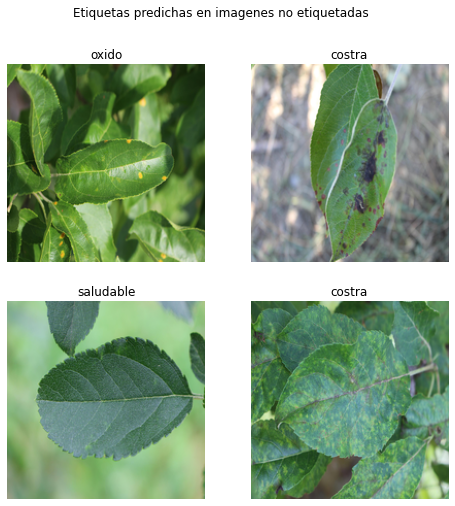

In [11]:
plt.figure(figsize=(8, 8))
plt.suptitle("Etiquetas predichas en imagenes no etiquetadas")

for i, logits in enumerate(predictions):
    if (i<4):
        class_idx = tf.argmax(logits).numpy()
        name = etiquetas[class_idx]
                
        plt.subplot(2, 2, i+1)
        plt.title(name)
        plt.imshow(training_data[i])
        plt.axis('off')
plt.show()

## Adecuación de datos self-supervised

In [48]:
# Creación de dataFrame con las etiquetas obtenidas de teacher
dfPredicted = pd.DataFrame()
nombresPred = []
etiquetasPred = []
for i, logits in enumerate(predictions):
    class_idx = tf.argmax(logits).numpy()
    name = etiquetas[class_idx]
    nombresPred.append('Test_'+str(i))
    etiquetasPred.append(name)
dfPredicted['image_id'] = nombresPred
dfPredicted['label'] = etiquetasPred
dfPredicted.head(4)

,image_id,label
0,Test_0,oxido
1,Test_1,costra
2,Test_2,saludable
3,Test_3,costra


In [6]:
# organizar datos de train segun su categoria
try:
    os.mkdir(pathBase+'etiquetadas_por_teacher')     
except:
    pass
pathEtiquetadas = pathBase+'etiquetadas_por_teacher/'
SortEnvironment(dfPredicted,etiquetas,pathPred,pathEtiquetadas)

## Preprocesamiento de datos predichos

### Aumento del 30% con datos predichos por teacher

In [15]:
batchSize_aug = 546             # aumento del 30% (546)

#Objeto para generacion de data augmentarion para train
dataTrain_predicted = PreprocData(batchSize_aug,targetSize,pathEtiquetadas)  

dataX_pred, dataY_pred = dataTrain_predicted.augmentation_dataGenerator(rotation=0, rescale=.1/255, shear=0, zoom=0, 
                                                                        flip_H = False, classMode = 'categorical',                                                                       
                                                                        labelNames = None)

# Adicionamos imagenes al dataset
dataX_student=np.vstack((dataX, dataX_pred))
dataY_student=np.vstack((dataY, dataY_pred))

print(f'imagenes de train iniciales: {dataX.shape[0]}')
print(f'imagenes predichas con teacher: {dataX_pred.shape[0]}')
print(f'imagenes con aumento: {dataX_student.shape[0]}')

Found 2099 images belonging to 4 classes.
imagenes de train iniciales: 1458
imagenes predichas con teacher: 546
imagenes con aumento: 2004


## Arquitectura de Red Neuronal

In [7]:
def Show_classification_report(model, test_x, test_y, batchSize_train):
        predictions = model.predict(test_x, batch_size=batchSize_train)
        pred = np.argmax(predictions, axis=1)
        test_y = np.argmax(test_y, axis=1)
        print(classification_report(test_y, pred, target_names=etiquetas))

In [8]:
studentModel_1 = TeacherModel_2
studentModel_1.trainable = True

In [9]:
# Congelamos las capas de los bloques convolucionales
for layer in studentModel_1.layers: 
#     if layer.name == 'conv2d_5': 
#     if layer.name == 'conv2d_3': 
    if layer.name == 'flatten': 
        break 
    layer.trainable = False 
    print('Capa ' + layer.name + ' congelada') 
studentModel_1.summary()

Capa conv2d congelada
Capa batch_normalization congelada
Capa max_pooling2d congelada
Capa dropout congelada
Capa conv2d_1 congelada
Capa batch_normalization_1 congelada
Capa max_pooling2d_1 congelada
Capa dropout_1 congelada
Capa conv2d_2 congelada
Capa batch_normalization_2 congelada
Capa max_pooling2d_2 congelada
Capa dropout_2 congelada
Capa conv2d_3 congelada
Capa batch_normalization_3 congelada
Capa max_pooling2d_3 congelada
Capa dropout_3 congelada
Capa conv2d_4 congelada
Capa batch_normalization_4 congelada
Capa max_pooling2d_4 congelada
Capa dropout_4 congelada
Capa conv2d_5 congelada
Capa batch_normalization_5 congelada
Capa max_pooling2d_5 congelada
Capa dropout_5 congelada
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 32)      896       
_________________________________________________________________
batch_normalization (B

In [24]:
epochs=20

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
studentModel_1.compile(loss="categorical_crossentropy", 
                          optimizer=Adam(learning_rate=0.001),
                          metrics=["accuracy"]) 

#Callbacks
model_cp = ModelCheckpoint(pathStudent_models+"studentModel_1_30.h5", monitor='val_loss', verbose=0, save_best_only=True, 
                           save_weights_only=False, mode='auto', save_freq='epoch')
early_stop = EarlyStopping(monitor='val_loss', patience=9, verbose=1)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

callbacks_list = [model_cp, early_stop, reduce_lr]

# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_student_1=studentModel_1.fit(dataX_student, dataY_student, batch_size=8, epochs=epochs,         
                             validation_split = 0.2, callbacks=callbacks_list)

[INFO]: Compilando el modelo...
[INFO]: Entrenando la red...
Epoch 1/20
201/201 [==============================] - 21s 98ms/step - loss: 1.3764 - accuracy: 0.8347 - val_loss: 2.9444 - val_accuracy: 0.3267
Epoch 2/20
201/201 [==============================] - 19s 97ms/step - loss: 1.4429 - accuracy: 0.8347 - val_loss: 2.4361 - val_accuracy: 0.3267
Epoch 3/20
201/201 [==============================] - 20s 98ms/step - loss: 1.5564 - accuracy: 0.8391 - val_loss: 2.6138 - val_accuracy: 0.3267
Epoch 4/20
201/201 [==============================] - 20s 98ms/step - loss: 1.4929 - accuracy: 0.8391 - val_loss: 2.9734 - val_accuracy: 0.3267
Epoch 5/20
201/201 [==============================] - 20s 98ms/step - loss: 1.5209 - accuracy: 0.8303 - val_loss: 2.4731 - val_accuracy: 0.3267
Epoch 6/20
201/201 [==============================] - 19s 97ms/step - loss: 1.4880 - accuracy: 0.8415 - val_loss: 2.8734 - val_accuracy: 0.3267
Epoch 7/20
201/201 [==============================] - 19s 96ms/step - loss:

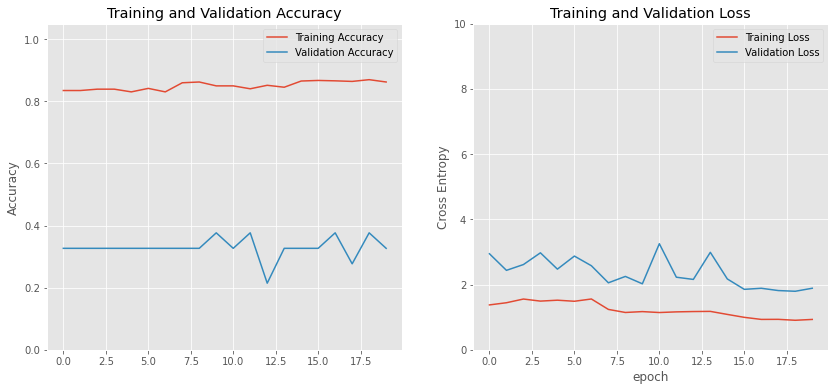

                        precision    recall  f1-score   support

                costra       0.96      0.94      0.95       118
multiples_enfermedades       0.67      0.33      0.44        18
                 oxido       0.95      0.98      0.96       124
             saludable       0.92      0.98      0.95       103

              accuracy                           0.93       363
             macro avg       0.87      0.81      0.83       363
          weighted avg       0.93      0.93      0.93       363



In [25]:
Plot_training_performance(H_student_1, 20, pathStudent_img+'/student_1')
# pruebas con datos de Test
Show_classification_report(studentModel_1,testX, testY,8)

In [17]:
StudentModel_1a_30 = load_model(pathStudent_models+"_studentModel_1_30.h5")
loss, acc = StudentModel_1a_30.evaluate(testX, testY, verbose=2)

12/12 - 2s - loss: 0.7289 - accuracy: 0.9311


### Aumento con 60% de datos predichos por teacher

In [10]:
# batchSize_aug = numImages/4
batchSize_aug = 1092              # aumento del 60%

#Objeto para generacion de data augmentarion para train
dataTrain_predicted = PreprocData(batchSize_aug,targetSize,pathEtiquetadas)  

dataX_pred, dataY_pred = dataTrain_predicted.augmentation_dataGenerator(rotation=0, rescale=.1/255, shear=0, zoom=0, 
                                                                        flip_H = False, classMode = 'categorical',                                                                       
                                                                        labelNames = None)

# Adicionamos imagenes al dataset
dataX_student=np.vstack((dataX, dataX_pred))
dataY_student=np.vstack((dataY, dataY_pred))

print(f'imagenes de train iniciales: {dataX.shape[0]}')
print(f'imagenes predichas con teacher: {dataX_pred.shape[0]}')
print(f'imagenes con aumento: {dataX_student.shape[0]}')

Found 2099 images belonging to 4 classes.
imagenes de train iniciales: 1458
imagenes predichas con teacher: 1092
imagenes con aumento: 2550


In [20]:
epochs=20

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
studentModel_1.compile(loss="categorical_crossentropy", 
                          optimizer=Adam(learning_rate=0.001),
                          metrics=["accuracy"]) 

# Callbacks
model_cp = ModelCheckpoint(pathStudent_models+"studentModel_1_60.h5", monitor='val_loss', verbose=0, save_best_only=True, 
                           save_weights_only=False, mode='auto', save_freq='epoch')
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

callbacks_list = [model_cp, early_stop, reduce_lr]

# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_student_1=studentModel_1.fit(dataX_student, dataY_student, batch_size=32, epochs=epochs,         
                             validation_split = 0.2, callbacks=callbacks_list)

[INFO]: Compilando el modelo...
[INFO]: Entrenando la red...
Epoch 1/20
64/64 [==============================] - 21s 317ms/step - loss: 1.1198 - accuracy: 0.7554 - val_loss: 2.2273 - val_accuracy: 0.3059
Epoch 2/20
64/64 [==============================] - 20s 310ms/step - loss: 1.1187 - accuracy: 0.7681 - val_loss: 2.0636 - val_accuracy: 0.3059
Epoch 3/20
64/64 [==============================] - 20s 311ms/step - loss: 1.1628 - accuracy: 0.7672 - val_loss: 1.9160 - val_accuracy: 0.3941
Epoch 4/20
64/64 [==============================] - 21s 326ms/step - loss: 1.1421 - accuracy: 0.7623 - val_loss: 2.1650 - val_accuracy: 0.1902
Epoch 5/20
64/64 [==============================] - 20s 308ms/step - loss: 1.1310 - accuracy: 0.7564 - val_loss: 2.0184 - val_accuracy: 0.3059
Epoch 6/20
64/64 [==============================] - 20s 308ms/step - loss: 1.1498 - accuracy: 0.7564 - val_loss: 2.0012 - val_accuracy: 0.3059
Epoch 7/20
64/64 [==============================] - 20s 311ms/step - loss: 1.1809

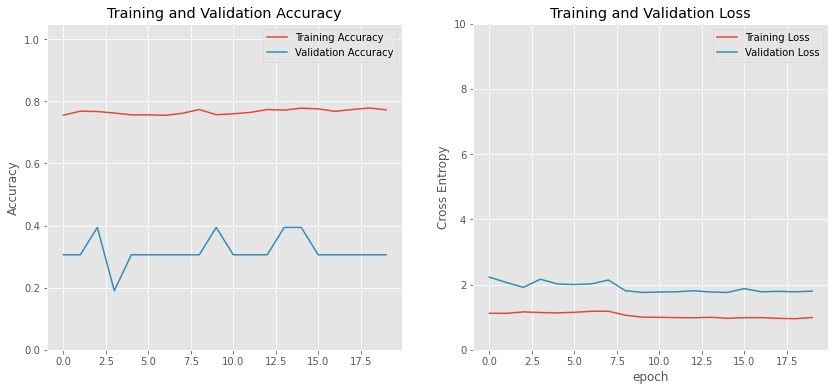

                        precision    recall  f1-score   support

                costra       0.95      0.92      0.94       118
multiples_enfermedades       0.80      0.22      0.35        18
                 oxido       0.95      0.98      0.96       124
             saludable       0.89      0.99      0.94       103

              accuracy                           0.93       363
             macro avg       0.90      0.78      0.80       363
          weighted avg       0.92      0.93      0.92       363



In [21]:
Plot_training_performance(H_student_1, 20, pathStudent_img+'/student_1_60')
# pruebas con datos de Test
Show_classification_report(studentModel_1,testX, testY, 32)

In [22]:
StudentModel_1_60 = load_model(pathStudent_models+"studentModel_1_60.h5")
loss, acc = StudentModel_1_60.evaluate(testX, testY, verbose=2)

12/12 - 2s - loss: 0.6789 - accuracy: 0.9284


In [23]:
studentModel_1.save(pathStudent_models+"studentModel_1_60.h5")
StudentModel_1_60 = load_model(pathStudent_models+"studentModel_1_60.h5")
loss, acc = StudentModel_1_60.evaluate(testX, testY, verbose=2)

12/12 - 2s - loss: 0.6885 - accuracy: 0.9284


### Aumento del 100%

In [10]:
# batchSize_aug = numImages/4
batchSize_aug = 1821              # aumento del 100%

# Objeto para generacion de data augmentarion para train
dataTrain_predicted = PreprocData(batchSize_aug,targetSize,pathEtiquetadas)  

dataX_pred, dataY_pred = dataTrain_predicted.augmentation_dataGenerator(rotation=0, rescale=.1/255, shear=0, zoom=0, 
                                                                        flip_H = False, classMode = 'categorical',                                                                       
                                                                        labelNames = None)

# Adicionamos imagenes al dataset
dataX_student=np.vstack((dataX, dataX_pred))
dataY_student=np.vstack((dataY, dataY_pred))

print(f'imagenes de train iniciales: {dataX.shape[0]}')
print(f'imagenes predichas con teacher: {dataX_pred.shape[0]}')
print(f'imagenes con aumento: {dataX_student.shape[0]}')

Found 2099 images belonging to 4 classes.
imagenes de train iniciales: 1458
imagenes predichas con teacher: 1821
imagenes con aumento: 3279


In [11]:
epochs=20

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
studentModel_1.compile(loss="categorical_crossentropy", 
                          optimizer=Adam(learning_rate=0.001),
                          metrics=["accuracy"]) 

#Callbacks
model_cp = ModelCheckpoint(pathStudent_models+"studentModel_1_100.h5", monitor='val_loss', verbose=0, save_best_only=True, 
                           save_weights_only=False, mode='auto', save_freq='epoch')
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

callbacks_list = [model_cp, early_stop, reduce_lr]

# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_student_1=studentModel_1.fit(dataX_student, dataY_student, batch_size=32, epochs=epochs,         
                             validation_split = 0.2, callbacks=callbacks_list)

[INFO]: Compilando el modelo...
[INFO]: Entrenando la red...
Epoch 1/20
82/82 [==============================] - 26s 308ms/step - loss: 1.3600 - accuracy: 0.6626 - val_loss: 1.9842 - val_accuracy: 0.3780
Epoch 2/20
82/82 [==============================] - 25s 308ms/step - loss: 1.3268 - accuracy: 0.6702 - val_loss: 1.9267 - val_accuracy: 0.3780
Epoch 3/20
82/82 [==============================] - 25s 308ms/step - loss: 1.3604 - accuracy: 0.6535 - val_loss: 1.9538 - val_accuracy: 0.2973
Epoch 4/20
82/82 [==============================] - 25s 307ms/step - loss: 1.3589 - accuracy: 0.6725 - val_loss: 2.7678 - val_accuracy: 0.2119
Epoch 5/20
82/82 [==============================] - 25s 307ms/step - loss: 1.3858 - accuracy: 0.6657 - val_loss: 1.9343 - val_accuracy: 0.3780
Epoch 6/20
82/82 [==============================] - 25s 307ms/step - loss: 1.3347 - accuracy: 0.6615 - val_loss: 2.0382 - val_accuracy: 0.2973
Epoch 7/20
82/82 [==============================] - 25s 307ms/step - loss: 1.3902

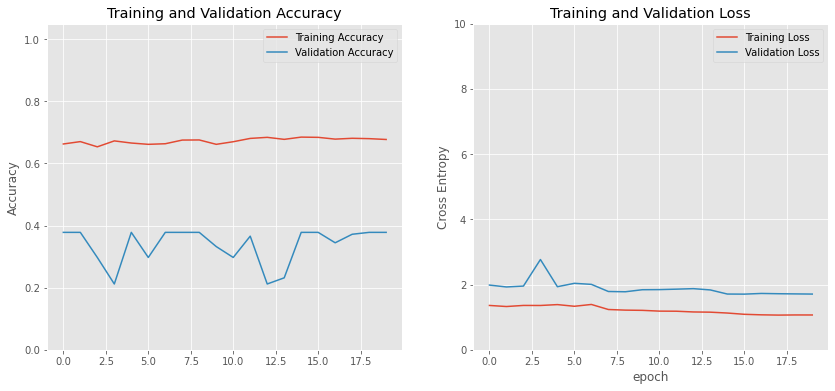

                        precision    recall  f1-score   support

                costra       0.96      0.95      0.95       118
multiples_enfermedades       0.60      0.33      0.43        18
                 oxido       0.93      0.98      0.95       124
             saludable       0.93      0.96      0.95       103

              accuracy                           0.93       363
             macro avg       0.86      0.80      0.82       363
          weighted avg       0.92      0.93      0.93       363



In [12]:
Plot_training_performance(H_student_1, 20, pathStudent_img+'/student_1_100')
# pruebas con datos de Test
Show_classification_report(studentModel_1,testX, testY, 32)

In [13]:
StudentModel_1_100 = load_model(pathStudent_models+"studentModel_1_100.h5")
loss, acc = StudentModel_1_100.evaluate(testX, testY, verbose=2)

12/12 - 2s - loss: 0.5922 - accuracy: 0.9284


In [19]:
# cargar modelos guardados
StudentModel_1_30 = load_model(pathStudent_models+'studentModel_1_30.h5')
StudentModel_1_60 = load_model(pathStudent_models+'studentModel_1_60.h5')
StudentModel_1_100 = load_model(pathStudent_models+'studentModel_1_100.h5')

# Evaluación del modelo
print('Modelo student con 30% de aumento')
loss, acc = StudentModel_1_30.evaluate(testX, testY, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
Show_classification_report(StudentModel_1_30,testX, testY, 8)

print('\nModelo student con 60% de aumento')
loss, acc = StudentModel_1_60.evaluate(testX, testY, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
Show_classification_report(StudentModel_1_60,testX, testY, 32)

print('\nModelo student con 100% de aumento')
loss, acc = StudentModel_1_100.evaluate(testX, testY, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
Show_classification_report(StudentModel_1_100,testX, testY, 32)

Modelo student con 30% de aumento
12/12 - 2s - loss: 0.7289 - accuracy: 0.9311
Restored model, accuracy: 93.11%
                        precision    recall  f1-score   support

                costra       0.95      0.92      0.93       118
multiples_enfermedades       0.64      0.50      0.56        18
                 oxido       0.97      0.98      0.97       124
             saludable       0.91      0.97      0.94       103

              accuracy                           0.93       363
             macro avg       0.87      0.84      0.85       363
          weighted avg       0.93      0.93      0.93       363


Modelo student con 60% de aumento
12/12 - 2s - loss: 0.6885 - accuracy: 0.9284
Restored model, accuracy: 92.84%
                        precision    recall  f1-score   support

                costra       0.95      0.92      0.94       118
multiples_enfermedades       0.80      0.22      0.35        18
                 oxido       0.95      0.98      0.96       124
   